In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import defaultdict
from copy import deepcopy
import time
import random
from scipy import stats
from scipy.stats import mode
import seaborn as sns
import warnings
from collections import defaultdict
warnings.filterwarnings("ignore")
from scipy.stats import chisquare

## Annotate pairs with the snp information

In [2]:
snps = pd.read_csv("output/03.annotation/snps_with_all_annotation.csv", index_col=0)
snps_columns_to_keep = [
    "pos", 
    "gene_name", 
    "gene_id", 
    "is_lineage",
    "in_antigen_epitope",
    "in_antigen_protein", 
    "in_known_ABR_position",
    "known_drug", 
    "in_possible_ABR_gene", 
    "possible_drug"

]
#snps

In [4]:
!mkdir output/04A.pair_annotation

mkdir: cannot create directory ‘output/04A.pair_annotation’: File exists


In [5]:

# Add gene and lineage  annotation to the results
results = pd.read_csv("output/02A.comutation_pvalues/results_file_allpairs.csv")
results = results.merge(snps[snps_columns_to_keep], left_on="position_i", right_on="pos")
results = results.merge(snps[snps_columns_to_keep], left_on="position_j", right_on="pos", suffixes=["_i", "_j"])
results.columns

print("total pairs", len(results))
print("total non-lineage pairs", len(results.query("not is_lineage_i and not is_lineage_j")))

results = results.query("not is_lineage_i and not is_lineage_j")

results = results[[
   'position_i', 'gene_name_i','position_j', 'gene_name_j',
    'n_mutations_i',
   'n_mutations_j', 'n_branches_with_i', 'n_branches_with_j',
   'n_muts_i_on_branch_j', 'n_muts_j_on_branch_i', 'n_muts_same_branch',
   'n_branch_with_i_no_j', 'n_branch_with_j_no_i', 'n_branch_i_and_j',
   'pval_beta_i_on_j', 'BH_critical_value', 'pval_beta_i_on_j_BH_sig',
    'is_lineage_i','is_lineage_j',
    'gene_id_i', 'gene_id_j', 
    "in_antigen_epitope_i",
    "in_antigen_protein_i", 
    "in_known_ABR_position_i",
    "known_drug_i", 
    "in_possible_ABR_gene_i", 
    "possible_drug_i",
    "in_antigen_epitope_j",
    "in_antigen_protein_j", 
    "in_known_ABR_position_j",
    "known_drug_j", 
    "in_possible_ABR_gene_j", 
    "possible_drug_j"
]]


total pairs 1625872
total non-lineage pairs 998764


In [6]:
to_filter = pd.read_csv("median_branch_length_between_mutations.csv", index_col=0).drop_duplicates(["position_i", "position_j"])
print(len(to_filter))
#to_filter = to_filter.query("median_distance>1000")

fresults = results.merge(to_filter[["position_i", "position_j", "median_distance"]], on=["position_i", "position_j"], how="left")
fresults = fresults.query("not median_distance > 1000")
print(len(fresults))
print(len(results))
results = fresults
results.to_csv("output/04A.pair_annotation/results_allpairs_annotated.csv")

print("total_significant", len(results.query("pval_beta_i_on_j_BH_sig")))
results.query("pval_beta_i_on_j_BH_sig").to_csv("output/04A.pair_annotation/results_significant_annotated.csv")

32600
998715
998764
total_significant 32567


In [7]:
32567/998715

0.03260890243963493

## Overall analysis of hits

In [8]:
def annotate(top_hits):
    def _separate_hits(logic_columns, current_df):
        is_hit = np.sum(current_df[logic_columns].values, axis=1) > 0

        hit_df = current_df.iloc[is_hit, :]
        current_df = current_df.iloc[~is_hit, :]
        return hit_df, current_df

    # start with the df of top hits. Get just the known antibiotic hits
    top_hits["annotation"] = 'other'
    logic_columns = ["in_known_ABR_position_i", "in_known_ABR_position_j"]

    antibiotic_hits, current_df = _separate_hits(logic_columns, top_hits)

    # if both are antibiotic, annotate that
    antibiotic_hits.loc[
        np.logical_and(
            antibiotic_hits.in_known_ABR_position_i.values, 
            antibiotic_hits.in_known_ABR_position_j.values
        ), 
        "annotation"
    ] = "between_known_AB"

    # if just one, annotate that
    antibiotic_hits.loc[
        np.logical_and(
            antibiotic_hits.in_known_ABR_position_i.values, 
            ~antibiotic_hits.in_known_ABR_position_j.values
        ), 
        "annotation"
    ] = "known_AB_second"

    antibiotic_hits.loc[
        np.logical_and(
            ~antibiotic_hits.in_known_ABR_position_i.values, 
            antibiotic_hits.in_known_ABR_position_j.values
        ), 
        "annotation"
    ] = "known_AB_first"

    # Then get the antigen proteins
    logic_columns = ['in_antigen_protein_i','in_antigen_protein_j',]

    antigen_hits, current_df = _separate_hits(logic_columns, current_df)

    # if just one, annotate that
    antigen_hits.loc[
        np.logical_or(
            antigen_hits.in_antigen_protein_i.values, 
            antigen_hits.in_antigen_protein_j.values
        ), 
        "annotation"
    ] = "one_antigen"

    antigen_hits.loc[
        np.logical_and(
            antigen_hits.in_antigen_protein_i.values, 
            antigen_hits.in_antigen_protein_j.values
        ), 
        "annotation"
    ] = "both_antigen"

    # then get the maybe antibiotic hits
    logic_columns = ["in_possible_ABR_gene_i", "in_possible_ABR_gene_j"]

    maybe_antibiotic_hits, current_df = _separate_hits(logic_columns, current_df)

    # if both are antibiotic, annotate that
    maybe_antibiotic_hits.loc[
        np.logical_and(
            maybe_antibiotic_hits.in_possible_ABR_gene_i.values, 
            maybe_antibiotic_hits.in_possible_ABR_gene_j.values
        ), 
        "annotation"
    ] = "between_maybe_AB"

    # if just one, annotate that
    maybe_antibiotic_hits.loc[
        np.logical_and(
            maybe_antibiotic_hits.in_possible_ABR_gene_i.values, 
            ~maybe_antibiotic_hits.in_possible_ABR_gene_j.values
        ), 
        "annotation"
    ] = "maybe_AB_second"

    maybe_antibiotic_hits.loc[
        np.logical_and(
            ~maybe_antibiotic_hits.in_possible_ABR_gene_i.values, 
            maybe_antibiotic_hits.in_possible_ABR_gene_j.values
        ), 
        "annotation"
    ] = "maybe_AB_first"

    return pd.concat([antigen_hits, antibiotic_hits, maybe_antibiotic_hits, current_df])

In [9]:

top_hits = pd.read_csv("output/04A.pair_annotation/results_significant_annotated.csv", index_col=0)
top_hits = annotate(top_hits)

In [10]:

logic_columns = ['in_antigen_epitope_i', 'in_antigen_protein_i',
   'in_known_ABR_position_i', 'in_possible_ABR_gene_i',
    'in_antigen_epitope_j', 'in_antigen_protein_j',
   'in_known_ABR_position_j',  'in_possible_ABR_gene_j']

to_analyze = np.sum(top_hits[logic_columns].values, axis =1) > 0

other_hits = top_hits.iloc[~to_analyze, :]
current_hits = top_hits.iloc[to_analyze, :]

print(to_analyze.shape, len(other_hits), len(current_hits))

(32567,) 12419 20148


In [11]:
top_hits.sort_values("pval_beta_i_on_j")[[
    "position_i",  "gene_name_i", "position_j", "gene_name_j", 
    "n_mutations_i", "n_mutations_j", "n_branches_with_j", "n_muts_i_on_branch_j","pval_beta_i_on_j", "annotation"
]].head(20)

,position_i,gene_name_i,position_j,gene_name_j,n_mutations_i,n_mutations_j,n_branches_with_j,n_muts_i_on_branch_j,pval_beta_i_on_j,annotation
3891,781687,rpsL,75233,None,918,44,24274,710,1.516782e-319,known_AB_second
7896,781687,rpsL,1722228,pks5,918,13,16173,594,8.033575e-287,known_AB_second
11209,781687,rpsL,4060588,esxW,918,117,16379,591,2.316092e-277,known_AB_second
14641,781687,rpsL,3446699,Rv3081,918,83,16441,589,7.240412e-273,known_AB_second
18026,781687,rpsL,2867575,lppB,918,25,16157,585,1.247823e-271,known_AB_second
21377,781687,rpsL,3894732,PPE60,918,60,17091,595,2.960305e-267,known_AB_second
233974,1473246,None,2155168,katG,589,2098,12564,409,3.046812e-260,between_known_AB
24842,781687,rpsL,908186,sseC2,918,5,14575,544,4.358255e-250,known_AB_second
27960,781687,rpsL,2122395,lldD2,918,277,19900,614,3.157481e-238,known_AB_second
233975,7582,gyrA,2155168,katG,779,2098,12564,490,1.789842e-236,between_known_AB


In [12]:
top_hits.sort_values("n_muts_i_on_branch_j", ascending=False)[[
    "position_i",  "gene_name_i", "position_j", "gene_name_j", 
    "n_mutations_i", "n_mutations_j", "n_branches_with_j", "n_muts_i_on_branch_j","pval_beta_i_on_j", "annotation"
]].head(20)

,position_i,gene_name_i,position_j,gene_name_j,n_mutations_i,n_mutations_j,n_branches_with_j,n_muts_i_on_branch_j,pval_beta_i_on_j,annotation
36212,2155168,katG,1096633,None,2098,5,60683,2046,2.787174e-23,known_AB_second
36152,761155,rpoB,1096633,None,1687,5,60683,1639,4.885734e-06,known_AB_second
31826,2155168,katG,1287112,None,2098,7,42982,1475,4.951269e-10,known_AB_second
68081,761155,rpoB,2626108,esxO,1687,40,45234,1325,5.779793e-50,known_AB_second
31767,761155,rpoB,1287112,None,1687,7,42982,1228,3.923636e-21,known_AB_second
3960,2155168,katG,75233,None,2098,44,24274,977,3.511023e-40,known_AB_second
61,2155168,katG,454333,Rv0376c,2098,5,22992,909,3.110937e-34,known_AB_second
36133,781687,rpsL,1096633,None,918,5,60683,909,8.961965e-231,known_AB_second
36139,4247429,embB,1096633,None,865,5,60683,846,4.531274e-37,known_AB_second
31748,781687,rpsL,1287112,None,918,7,42982,817,3.761259e-236,known_AB_second


In [13]:
print(top_hits.groupby("annotation").size())

annotation
between_known_AB      532
between_maybe_AB      266
both_antigen         1649
known_AB_first       1817
known_AB_second      3185
maybe_AB_first        416
maybe_AB_second      1635
one_antigen         10648
other               12419
dtype: int64


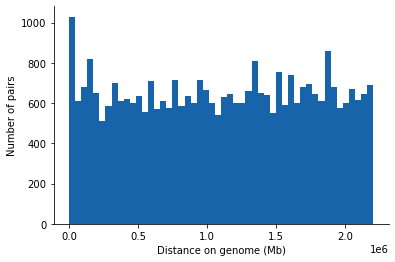

In [14]:
def dist(p1,p2):
    
    total_nucleotides = 4411532    

    max_dist = int(total_nucleotides / 2)
    # accounts for circularization of genome
    d1 = np.abs(p1 - p2)
    
    #print(i,j,d1)
    if d1 > max_dist:
        i,j=sorted([p1,p2])
        #print("too_far!", d1)
        i = i + total_nucleotides
        d1 = i-j
        #print("new distance", d1)
        
    return d1

pal = sns.color_palette("Blues",4)

for_display = top_hits
for_display["mutation_distance"] = [dist(x,y) for x,y in zip(for_display.position_i, for_display.position_j)]
plt.hist(for_display.mutation_distance, 50, color=pal[3])
plt.xlabel("Distance on genome (Mb)")
plt.ylabel("Number of pairs")
sns.despine()
plt.savefig("figures/sequential_mutations_distance.pdf")

In [15]:
for_display.sort_values("mutation_distance")

,position_i,gene_name_i,position_j,gene_name_j,n_mutations_i,n_mutations_j,n_branches_with_i,n_branches_with_j,n_muts_i_on_branch_j,n_muts_j_on_branch_i,...,possible_drug_i,in_antigen_epitope_j,in_antigen_protein_j,in_known_ABR_position_j,known_drug_j,in_possible_ABR_gene_j,possible_drug_j,median_distance,annotation,mutation_distance
168678,761156,rpoB,761155,rpoB,37,1687,152,9165,22,0,...,RIF,False,True,True,"RIF,RIF,RIF,RIF,RIF,RIF,RIF,RIF,RIF,RIF,RIF,RIF",True,RIF,25.360589,between_known_AB,1
137027,2197365,None,2197366,None,6,6,6,8,1,0,...,NaN,False,False,False,NaN,False,NaN,59.910898,other,1
137029,2197367,None,2197366,None,7,6,6,8,1,0,...,NaN,False,False,False,NaN,False,NaN,59.910898,other,1
955528,1472151,None,1472150,None,5,8,4,8,1,0,...,"LZD,KAN,CAP,STM,AMI",False,False,False,NaN,True,"LZD,KAN,CAP,STM,AMI",24.773185,between_maybe_AB,1
178482,3173126,None,3173127,None,5,5,28,30,1,0,...,NaN,False,False,False,NaN,False,NaN,62.622001,other,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
763104,2986827,Rv2670c,781687,rpsL,96,918,671,5303,25,0,...,NaN,False,False,True,"STM,STM",True,STM,70.974427,known_AB_first,2205140
45042,3545401,None,1340208,PPE18,12,30,84,21626,10,0,...,NaN,False,True,False,NaN,False,NaN,507.090417,one_antigen,2205193
81321,3729898,PPE54,1523817,moeY,5,5,8,6522,4,0,...,NaN,False,False,False,NaN,False,NaN,93.841946,one_antigen,2205451
87417,1094602,None,3300658,fadD29,5,5,2,766,5,0,...,NaN,False,False,False,NaN,False,NaN,112.467797,other,2205476


In [16]:
top_hits.to_csv("output/04A.pair_annotation/results_significant_annotated_categories.csv")

### Enrichment calculations

In [17]:
all_hits = pd.read_csv("output/04A.pair_annotation/results_allpairs_annotated.csv")
all_hits = annotate(all_hits)

In [18]:
all_hits.to_csv("output/04A.pair_annotation/results_allpairs_annotation_withcategories.csv")
print(all_hits.groupby("annotation").size())

annotation
between_known_AB      6044
between_maybe_AB      3514
both_antigen         59834
known_AB_first       64918
known_AB_second      64918
maybe_AB_first       42646
maybe_AB_second      42646
one_antigen         350819
other               363376
dtype: int64


#### Question 1: are the overlapping hits an enrichment in some way based on our expectation from the distribution of SNPs?

In [20]:
## Actual numbers: 159 epitopes, 774 antigens, 250 known resistance, 814 possible resistance, 2747 no category
total_snps = len(snps)

p_epitope = 159/total_snps
p_antigen = 774/total_snps
p_known_R = 250/total_snps
p_possible_R = (814-250)/total_snps
p_other = (total_snps - 814 -774)/total_snps

# bang this out
e_between_known_AB = p_known_R * p_known_R
e_between_maybe_AB = p_possible_R * p_possible_R
e_both_antigen = p_antigen * p_antigen

e_known_AB_first = p_known_R * (1-p_known_R)
e_known_AB_second = p_known_R * (1-p_known_R)

e_maybe_AB_first = p_possible_R * (p_other)
e_maybe_AB_second = p_possible_R * (p_other)

e_one_antigen = 2 * p_antigen * (p_other + p_possible_R)
e_other = p_other * p_other


top_hits_values = all_hits.groupby("annotation").size()
labels = all_hits.groupby("annotation").size().index

all_hits_expectation = np.array([e_between_known_AB, e_between_maybe_AB, e_both_antigen, e_known_AB_first, 
                        e_known_AB_second, e_maybe_AB_first, e_maybe_AB_second, e_one_antigen, e_other]) * len(all_hits)

## Table of nice results

result_df = pd.DataFrame({
                          "actual_pair_freq": top_hits_values, 
                          "expected_pair_freq": all_hits_expectation})
print(chisquare(top_hits_values,  f_exp=all_hits_expectation))

print(result_df)
result_df1 = result_df
result_df1["chi_square"] = chisquare(top_hits_values,  f_exp=all_hits_expectation)[0]
result_df1["p_value"] = chisquare(top_hits_values,  f_exp=all_hits_expectation)[1]
result_df1.to_csv("output/04A.chisquare_all_pairs_vs_expected.csv")

Power_divergenceResult(statistic=145343.32622456466, pvalue=0.0)
                  actual_pair_freq  expected_pair_freq
annotation                                            
between_known_AB              6044         2774.695570
between_maybe_AB              3514        14121.912992
both_antigen                 59834        26596.056371
known_AB_first               64918        49866.828782
known_AB_second              64918        49866.828782
maybe_AB_first               42646        78997.580655
maybe_AB_second              42646        78997.580655
one_antigen                 350819       255583.291074
other                       363376       441910.225119


In [21]:
result_df1["actual_percent"] = result_df1.actual_pair_freq /  result_df1.actual_pair_freq.sum()
result_df1["expected_percent"] = result_df1.expected_pair_freq /  result_df1.expected_pair_freq.sum()
result_df1["category"] = result_df1.index
result_df1

,actual_pair_freq,expected_pair_freq,chi_square,p_value,actual_percent,expected_percent,category
annotation,,,,,,,
between_known_AB,6044,2774.695570,145343.326225,0.0,0.006052,0.002778,between_known_AB
between_maybe_AB,3514,14121.912992,145343.326225,0.0,0.003519,0.014140,between_maybe_AB
both_antigen,59834,26596.056371,145343.326225,0.0,0.059911,0.026630,both_antigen
known_AB_first,64918,49866.828782,145343.326225,0.0,0.065002,0.049931,known_AB_first
known_AB_second,64918,49866.828782,145343.326225,0.0,0.065002,0.049931,known_AB_second
maybe_AB_first,42646,78997.580655,145343.326225,0.0,0.042701,0.079099,maybe_AB_first
maybe_AB_second,42646,78997.580655,145343.326225,0.0,0.042701,0.079099,maybe_AB_second
one_antigen,350819,255583.291074,145343.326225,0.0,0.351270,0.255912,one_antigen
other,363376,441910.225119,145343.326225,0.0,0.363844,0.442479,other


In [19]:
# actual vs expected epitopes
result_df1.loc["both_antigen","actual_percent"] + result_df1.loc["one_antigen","actual_percent"], result_df1.loc["both_antigen","expected_percent"] + result_df1.loc["one_antigen","expected_percent"]


(0.41118222122543463, 0.32117919906735626)

In [22]:
# actual vs expected epitopes
result_df1.loc["between_known_AB","actual_percent"] + result_df1.loc["known_AB_first","actual_percent"] + result_df1.loc["known_AB_second","actual_percent"], \
result_df1.loc["between_known_AB","expected_percent"] + result_df1.loc["known_AB_first","expected_percent"]+ result_df1.loc["known_AB_second","expected_percent"]


(0.1360548304571374, 0.10264024584939338)

#### Question 2: are the top hits enriched relative to all the cooccurences?

In [23]:


top_hits_values = top_hits.groupby("annotation").size().values
all_hits_expectation = all_hits.groupby("annotation").size().values / len(all_hits) * len(top_hits)

print(top_hits_values, all_hits_expectation)
print(chisquare(top_hits_values,  f_exp=all_hits_expectation))

## Table of nice results

result_df = pd.DataFrame({ 
    "category": top_hits.groupby("annotation").size().index,
    "actual_hit_freq": top_hits_values, 
    "expected_hit_freq": all_hits_expectation})

print(result_df)
result_df2 = result_df

[  532   266  1649  1817  3185   416  1635 10648 12419] [  197.08820635   114.58768317  1951.12106857  2116.90472858
  2116.90472858  1390.63925344  1390.63925344 11439.82254497
 11849.2925329 ]
Power_divergenceResult(statistic=2205.588910600862, pvalue=0.0)
           category  actual_hit_freq  expected_hit_freq
0  between_known_AB              532         197.088206
1  between_maybe_AB              266         114.587683
2      both_antigen             1649        1951.121069
3    known_AB_first             1817        2116.904729
4   known_AB_second             3185        2116.904729
5    maybe_AB_first              416        1390.639253
6   maybe_AB_second             1635        1390.639253
7       one_antigen            10648       11439.822545
8             other            12419       11849.292533


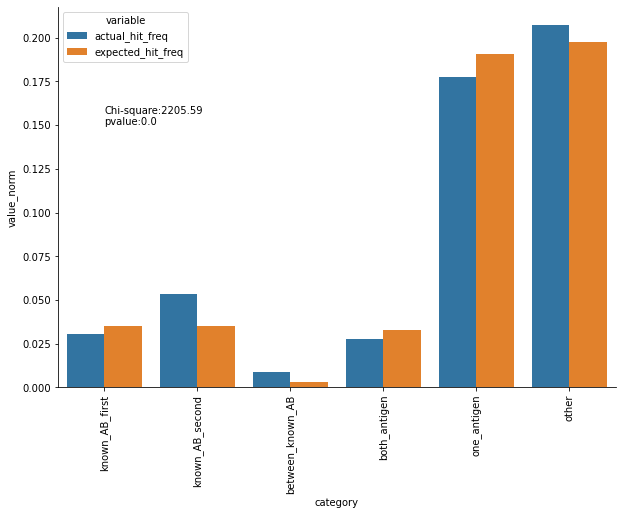

In [24]:
## Make a bar chart of actual vs. observations

# sort the result dataframe in desired order

cats_to_remove = ["between_maybe_AB", "maybe_AB_first", "maybe_AB_second"]
result_df = result_df.query("category not in @cats_to_remove")

desired_order = ["known_AB_first", "known_AB_second", "between_known_AB", "both_antigen", "one_antigen", "other"]
sorter = [desired_order.index(x) for x in result_df.category]
result_df = result_df.iloc[sorter, :]

to_plot = result_df.melt(["category"])
#to_plot["value"] = [np.log10(x) for x in to_plot.value]

# normalize the result dataframe
to_plot["value_norm"] = to_plot.value / to_plot.value.sum()

fig= plt.figure(figsize=(10,7))
ax = fig.gca()

sns.barplot(data = to_plot, x='category', y = 'value_norm', hue='variable', 
            #palette={"actual_hit_freq":pal[2], "expected_hit_freq":pal[7]}
           )
plt.xticks(rotation=90)
cs = chisquare(top_hits_values,  f_exp=all_hits_expectation)

ax.text(x = 0, y=.15, s=f"Chi-square:{np.round(cs.statistic,2)}\npvalue:{cs.pvalue}")
sns.despine()



top_hits.sort_values("pval_beta_i_on_j").iloc[0:100].groupby("annotation").size().values## Question 3: are the highest pvalue hits enriched wrt the freq of all pairs?

In [25]:
top_hits.sort_values("pval_beta_i_on_j").iloc[0:100].groupby("annotation").size()

annotation
between_known_AB    10
both_antigen         2
known_AB_first       3
known_AB_second     56
one_antigen         22
other                7
dtype: int64

In [26]:
top_hits_values = top_hits.sort_values("pval_beta_i_on_j").iloc[0:100].groupby("annotation").size().values
all_hits_expectation = top_hits.groupby("annotation").size().values / len(top_hits) * 100

top_hits_values = [10,0,2,3,56,0,0,22,7]
print(chisquare(top_hits_values,  f_exp=all_hits_expectation))

result_df = pd.DataFrame({ 
    "category": top_hits.groupby("annotation").size().index,
    "actual_top_hit_freq": top_hits_values, 
    "expected_top_hit_freq": all_hits_expectation})

print(result_df)
result_df3 = result_df

Power_divergenceResult(statistic=300.36708926608793, pvalue=3.439813240829776e-60)
           category  actual_top_hit_freq  expected_top_hit_freq
0  between_known_AB                   10               1.633555
1  between_maybe_AB                    0               0.816778
2      both_antigen                    2               5.063408
3    known_AB_first                    3               5.579267
4   known_AB_second                   56               9.779838
5    maybe_AB_first                    0               1.277367
6   maybe_AB_second                    0               5.020419
7       one_antigen                   22              32.695674
8             other                    7              38.133694


In [27]:
## What are the top hits in the "other" category? 
top_hits.query("annotation=='other'").sort_values("pval_beta_i_on_j").head(20)

,position_i,gene_name_i,position_j,gene_name_j,n_mutations_i,n_mutations_j,n_branches_with_i,n_branches_with_j,n_muts_i_on_branch_j,n_muts_j_on_branch_i,...,possible_drug_i,in_antigen_epitope_j,in_antigen_protein_j,in_known_ABR_position_j,known_drug_j,in_possible_ABR_gene_j,possible_drug_j,median_distance,annotation,mutation_distance
539080,2829918,None,3136335,None,75,314,1118,7632,75,0,...,NaN,False,False,False,NaN,False,NaN,122.821904,other,306417
539081,1169308,None,3136335,None,70,314,198,7632,69,0,...,NaN,False,False,False,NaN,False,NaN,126.727318,other,1967027
587409,2829918,None,2339255,Rv2082,75,44,1118,20062,75,0,...,NaN,False,False,False,NaN,False,NaN,570.380767,other,490663
539082,3382737,None,3136335,None,58,314,144,7632,58,0,...,NaN,False,False,False,NaN,False,NaN,NaN,other,246402
587410,1169308,None,2339255,Rv2082,70,44,198,20062,70,0,...,NaN,False,False,False,NaN,False,NaN,574.225783,other,1169947
807568,2765888,lipP,3297704,pks15,32,5,62,446,31,0,...,NaN,False,False,False,NaN,False,NaN,50.029522,other,531816
587411,3382737,None,2339255,Rv2082,58,44,144,20062,58,0,...,NaN,False,False,False,NaN,False,NaN,NaN,other,1043482
536497,4385933,Rv3900c,2030521,esxM,42,69,606,6159,42,0,...,NaN,False,False,False,NaN,False,NaN,777.769767,other,2056120
507868,4385933,Rv3900c,2240062,None,42,5,606,5611,41,0,...,NaN,False,False,False,NaN,False,NaN,599.641118,other,2145871
193147,2765888,lipP,975542,Rv0876c,32,5,62,884,31,0,...,NaN,False,False,False,NaN,False,NaN,93.012115,other,1790346


In [28]:
result_df1

,actual_pair_freq,expected_pair_freq,chi_square,p_value,actual_percent,expected_percent,category
annotation,,,,,,,
between_known_AB,6044,2774.695570,145343.326225,0.0,0.006052,0.002778,between_known_AB
between_maybe_AB,3514,14121.912992,145343.326225,0.0,0.003519,0.014140,between_maybe_AB
both_antigen,59834,26596.056371,145343.326225,0.0,0.059911,0.026630,both_antigen
known_AB_first,64918,49866.828782,145343.326225,0.0,0.065002,0.049931,known_AB_first
known_AB_second,64918,49866.828782,145343.326225,0.0,0.065002,0.049931,known_AB_second
maybe_AB_first,42646,78997.580655,145343.326225,0.0,0.042701,0.079099,maybe_AB_first
maybe_AB_second,42646,78997.580655,145343.326225,0.0,0.042701,0.079099,maybe_AB_second
one_antigen,350819,255583.291074,145343.326225,0.0,0.351270,0.255912,one_antigen
other,363376,441910.225119,145343.326225,0.0,0.363844,0.442479,other


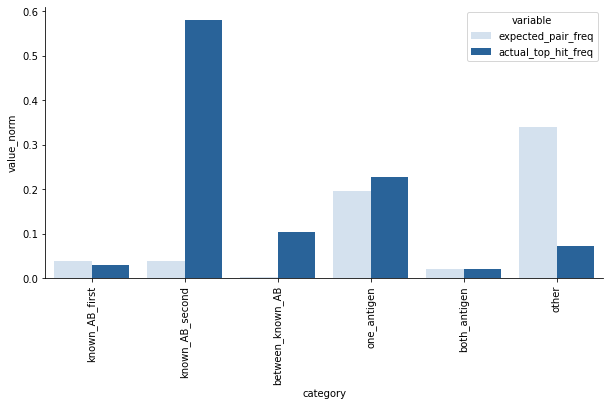

In [29]:
### Combine all three into bar plot
def _process_result_df(result_df):
    cats_to_remove = ["between_maybe_AB", "maybe_AB_first", "maybe_AB_second"]
    result_df = result_df.query("category not in @cats_to_remove")

    desired_order = ["known_AB_first", "known_AB_second", "between_known_AB", "one_antigen", "both_antigen", "other"]


    to_plot = result_df.melt(["category"])
    to_plot["category_sorter"] = [desired_order.index(x) for x in to_plot.category]
    #to_plot["value"] = [np.log10(x) for x in to_plot.value]

    # normalize the result dataframe
    to_plot["value_norm"] = to_plot.value / (to_plot.value.sum()/2)
    
    return to_plot

pal = sns.color_palette("Blues",4)

toplot1 = _process_result_df(result_df1)
toplot2 = _process_result_df(result_df2)
toplot3 = _process_result_df(result_df3)

to_plot = pd.concat([toplot1, toplot2, toplot3])

categories_to_keep = ["expected_pair_freq", "actual_top_hit_freq"]
to_plot = to_plot.query("variable in @categories_to_keep")

desired_order = ["expected_pair_freq", "actual_pair_freq", "actual_hit_freq", "actual_top_hit_freq"]
to_plot["sorter"] = [desired_order.index(x) for x in to_plot.variable]
to_plot = to_plot.sort_values(["sorter", "category_sorter"])


fig= plt.figure(figsize=(10,5))
ax = fig.gca()

sns.barplot(data = to_plot, x='category', y = 'value_norm', hue='variable',
            palette=[pal[0], pal[3]]
            
           )
plt.xticks(rotation=90)
#cs = chisquare(top_hits_values,  f_exp=all_hits_expectation)

sns.despine()
plt.savefig("figures/sequential_mutations_category.pdf")

In [28]:
to_plot

,category,variable,value,category_sorter,value_norm,sorter
8,known_AB_first,expected_pair_freq,50057.608778,0,0.044060,0
9,known_AB_second,expected_pair_freq,50057.608778,1,0.044060,0
6,between_known_AB,expected_pair_freq,2797.074756,2,0.002462,0
10,one_antigen,expected_pair_freq,285377.633286,3,0.251187,0
7,both_antigen,expected_pair_freq,35404.588292,4,0.031163,0
11,other,expected_pair_freq,404921.201301,5,0.356408,0
2,known_AB_first,actual_top_hit_freq,0.000000,0,0.000000,3
3,known_AB_second,actual_top_hit_freq,65.000000,1,0.673938,3
0,between_known_AB,actual_top_hit_freq,7.000000,2,0.072578,3
4,one_antigen,actual_top_hit_freq,22.000000,3,0.228102,3
